<a href="https://colab.research.google.com/github/PrithiviRajMK/ScalerProjects/blob/main/Zee_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
### Zee wants to know, 
*   Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Packages

In [1]:
# Import required packages
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing Libs
import pandas as pd #data processing using DataFrames
import numpy as np #Numrical calculations
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler 
#Plotting Libs
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import plotly.express as px # plotting
#Statistics Libs
from scipy.stats import binom, poisson,expon # For Probability Distribution.
import plotly.figure_factory as ff # distplot 
from scipy.stats import ttest_ind, f_oneway, kruskal # numeric Vs catogerical
from scipy.stats import chi2_contingency
import scipy.stats as st# categorical Vs categorical
from datetime import datetime
from scipy.stats import pearsonr, spearmanr # numeric Vs numeric

from scipy.stats import kstest,levene,norm,shapiro # cdf
from statsmodels.graphics.gofplots import qqplot_2samples, qqplot

from statsmodels.distributions.empirical_distribution import ECDF
# Prec


#### Import & Load data

In [2]:
df_movies=  pd.read_fwf('/content/drive/MyDrive/Scaler Zee/zee-movies.dat',sep='\t', encoding='ISO-8859-1')
df_rating=  pd.read_fwf('/content/drive/MyDrive/Scaler Zee/zee-ratings.dat', encoding='ISO-8859-1')
df_users=  pd.read_fwf('/content/drive/MyDrive/Scaler Zee/zee-users.dat', encoding='ISO-8859-1')


# Statistical Summary

### Meta-data of dataset

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Movie ID::Title::Genres  3883 non-null   object
 1   Unnamed: 1               100 non-null    object
 2   Unnamed: 2               51 non-null     object
dtypes: object(3)
memory usage: 91.1+ KB


In [4]:
df_movies.head()


,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [5]:
df_movies[['MovieID','Title','Genres']] = df_movies['Movie ID::Title::Genres'].str.split('::',expand=True)
pattern = r'\((\d+)\)'
df_movies['Release_year'] = df_movies['Title'].str.extract(pattern)
df_movies['Title']=df_movies['Title'].str.replace(r'\(\d+\)', '').str.strip()
df_movies.drop(df_movies.columns[[0, 1, 2]], axis=1, inplace=True)

In [6]:
df_movies.head()

,MovieID,Title,Genres,Release_year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [7]:
df_rating[['UserID','MovieID','Rating','Timestamp']] = df_rating['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
df_rating.drop('UserID::MovieID::Rating::Timestamp', axis=1, inplace=True)

In [8]:
df_rating.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
df_users[['UserID','Gender','Age','Occupation','Zip-code']] = df_users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True)
df_users.drop('UserID::Gender::Age::Occupation::Zip-code', axis=1, inplace=True)

In [10]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Description of the dataframe

In [11]:
df_movies.describe()

,MovieID,Title,Genres,Release_year
count,3883,3883,3858,3864
unique,3883,3841,360,81
top,1,Hamlet,Drama,1996
freq,1,5,830,344


In [12]:
df_rating.describe(include='all')

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


In [13]:
# only object type columns
df_users.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25,4,48104
freq,1,4331,2096,759,19


### Shape of the data

In [14]:
### Data shape
print("Zee Movies dataset has {} rows and {} columns.".format(df_movies.shape[0], df_movies.shape[1]))
print("Zee Users dataset has {} rows and {} columns.".format(df_users.shape[0], df_users.shape[1]))
print("Zee Rating dataset has {} rows and {} columns.".format(df_rating.shape[0], df_rating.shape[1]))

Zee Movies dataset has 3883 rows and 4 columns.
Zee Users dataset has 6040 rows and 5 columns.
Zee Rating dataset has 1000209 rows and 4 columns.


### Size & Count

In [15]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       3883 non-null   object
 1   Title         3883 non-null   object
 2   Genres        3858 non-null   object
 3   Release_year  3864 non-null   object
dtypes: object(4)
memory usage: 121.5+ KB


In [16]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [17]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


### Column Names

### Column data typess

In [18]:
### Data type of all attributes
df_movies.dtypes

MovieID         object
Title           object
Genres          object
Release_year    object
dtype: object

In [19]:
### Data type of all attributes
df_rating.dtypes

UserID       object
MovieID      object
Rating       object
Timestamp    object
dtype: object

In [20]:
### Data type of all attributes
df_users.dtypes

UserID        object
Gender        object
Age           object
Occupation    object
Zip-code      object
dtype: object

# Data Pre-processing

### Check for Missing Values

In [21]:
# Missing Values
null_values= pd.DataFrame({"Null Values" : df_movies.isna().sum(),
                           "Percentage Null Value": (df_movies.isna().sum()/(df_movies.shape[0])*(100))})
null_values

,Null Values,Percentage Null Value
MovieID,0,0.000000
Title,0,0.000000
Genres,25,0.643832
Release_year,19,0.489312


In [49]:

ids_to_select = [258, 265, 1205, 1306, 1360, 2142, 2705, 3864]
dfs=df_movies.loc[df_movies['Movie_ID'].isin(ids_to_select)]
print(dfs)

Empty DataFrame
Columns: [Movie_ID, Title, Genres, Release_year]
Index: []


In [22]:
df_movies[df_movies.isnull().any(axis=1)]

,MovieID,Title,Genres,Release_year
62,63,Don't Be a Menace to South Central While Drink...,None,NaN
197,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",None,1964
359,363,"Wonderful, Horrible Life of Leni Riefenstahl, ...",None,NaN
464,468,"Englishman Who Went Up a Hill, But Came Down a...",None,NaN
720,729,"Institute Benjamenta, or This Dream People Cal...",None,1995
740,750,Dr. Strangelove or: How I Learned to Stop Worr...,None,NaN
783,793,My Life and Times With Antonin Artaud (En comp...,None,NaN
787,797,"Old Lady Who Walked in the Sea, The (Vieille q...",None,NaN
1134,1150,"Return of Martin Guerre, The (Retour de Martin...",None,1982
1160,1176,"Double Life of Veronique, The (La Double Vie d...",None,1991


In [23]:
df_movies = df_movies.dropna()


In [24]:
df_movies.isnull().sum().sum()

0

In [25]:
df_users.isnull().sum().sum()

0

In [26]:
df_rating.isnull().sum().sum()

0

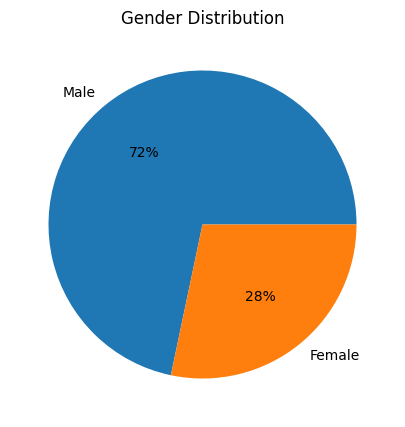

In [27]:
plt.figure(figsize=(15,5))
plt.pie(df_users['Gender'].value_counts(),labels=['Male','Female'], autopct='%.0f%%')
plt.title('Gender Distribution')
plt.show()

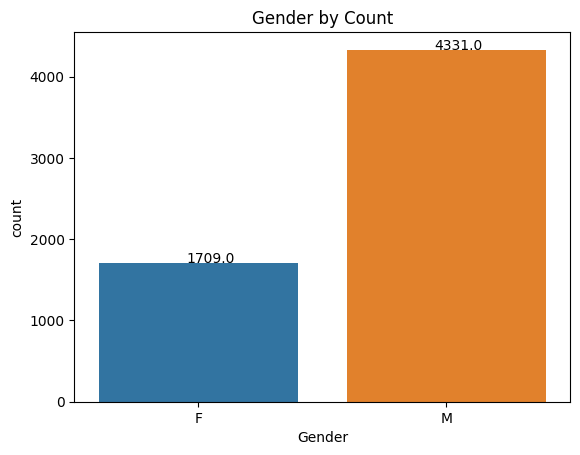

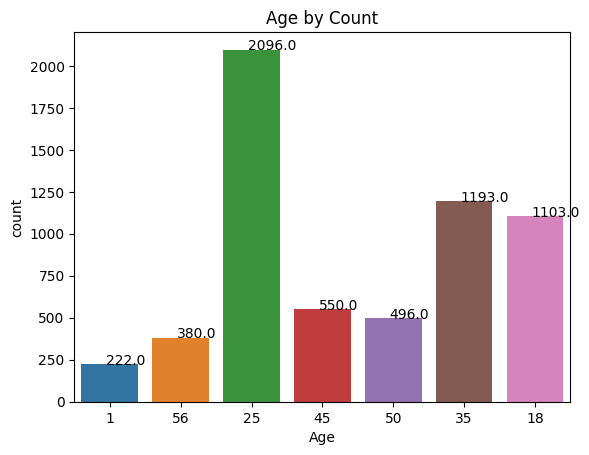

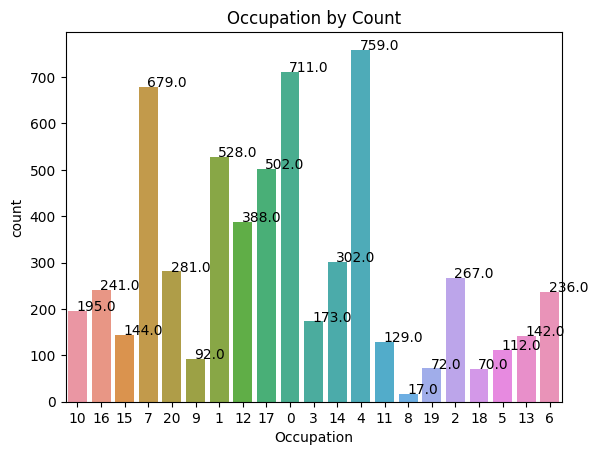

In [28]:
Sub_col=['Gender','Age','Occupation']
# Count plot of attributes
for col in Sub_col:
  ax = sns.countplot(data=df_users, x=col)
  plt.title(f"{col} by Count")
  for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.35, p.get_height()+0.05))
  plt.show()
  print()

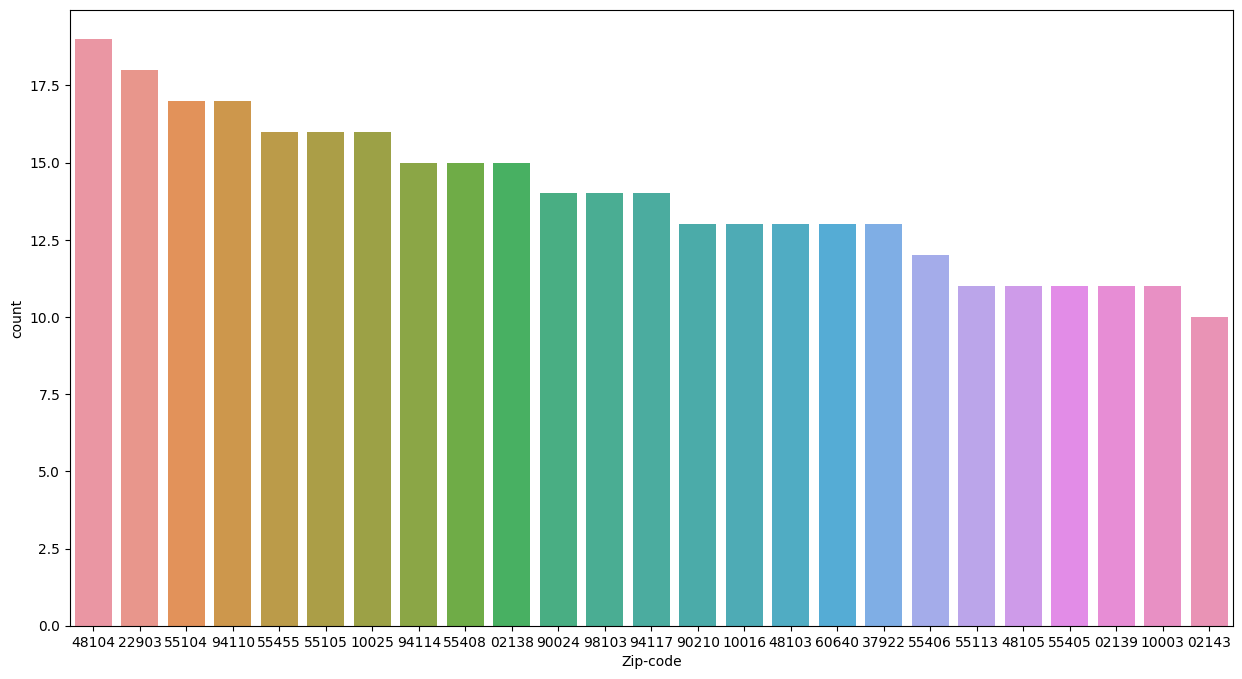

In [29]:
plt.figure(figsize=(15,8))
sns.countplot(data=df_users, x='Zip-code', order=df_users['Zip-code'].value_counts().iloc[:25].index)
plt.show()

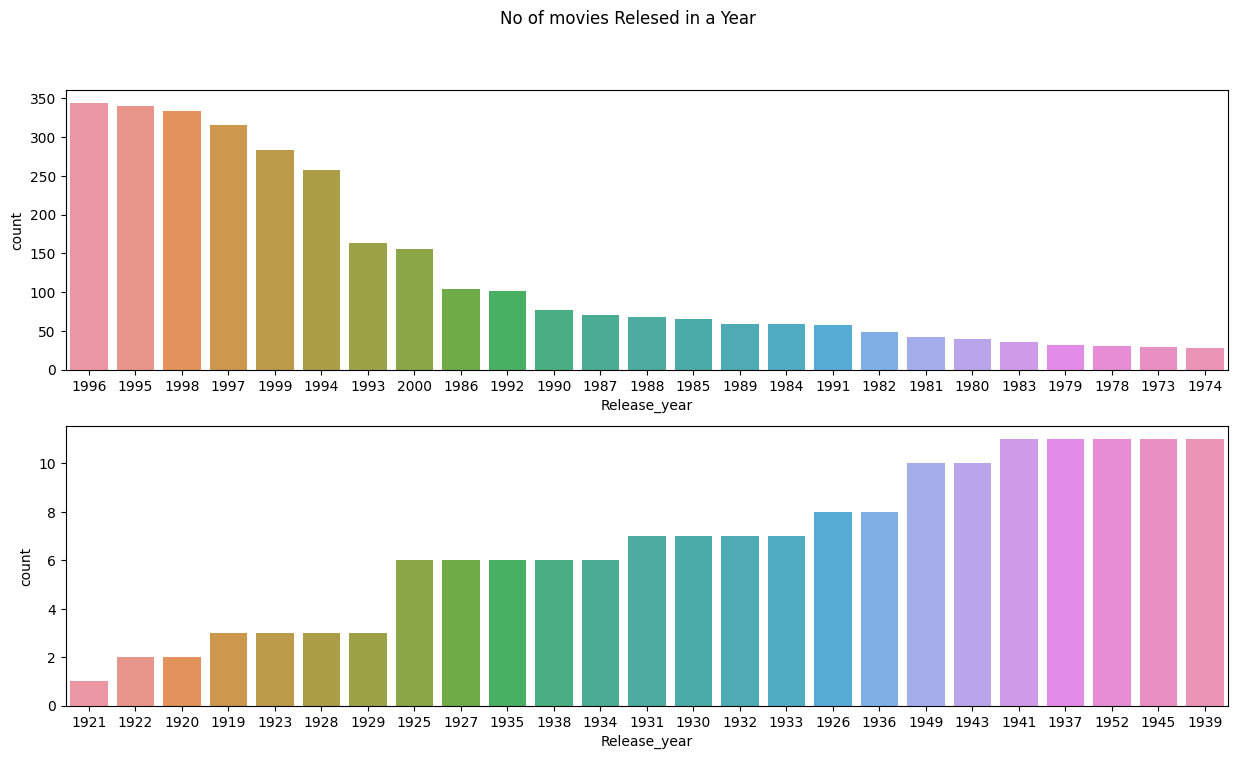

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# plot data on the first subplot
sns.countplot(data=df_movies, x='Release_year',order=df_movies['Release_year'].value_counts().iloc[:25].index,ax=axes[0])

# plot data on the second subplot
sns.countplot(data=df_movies, x='Release_year',order=df_movies['Release_year'].value_counts(ascending=True).iloc[:25].index,ax=axes[1])

# set overall title for the figure
fig.suptitle("No of movies Relesed in a Year")

# show the plot
plt.show()

In [31]:
movie_ratings = pd.merge(df_rating, df_movies, on='MovieID')
movie_ratings

,UserID,MovieID,Rating,Timestamp,Title,Genres,Release_year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,Drama,1975
...,...,...,...,...,...,...,...
996139,5949,2198,5,958846401,Modulations,Documentary,1998
996140,5675,2703,3,976029116,Broken Vessels,Drama,1998
996141,5780,2845,1,958153068,White Boys,Drama,1999
996142,5851,3607,5,957756608,One Little Indian,Comedy|Drama|Western,1973


### Pearson Recommended

In [33]:

# calculate the mean rating for each movie
mean_ratings = movie_ratings.groupby(['Title'])['Rating'].mean().reset_index()
print(mean_ratings)

# create a pivot table with movie titles as rows and user ratings as columns
user_ratings = movie_ratings.pivot_table(index='UserID', columns='Title', values='Rating')

# fill in missing values with zeros
user_ratings = user_ratings.fillna(0)
print(user_ratings)

# calculate the Pearson Correlation between all pairs of movies
correlations = np.corrcoef(user_ratings.T)
print(correlations)

                                    Title         Rating
0                         $1,000,000 Duck   6.868525e+34
1                           'Night Mother   7.622188e+67
2                      'Til There Was You   4.121987e+49
3                             'burbs, The  1.460150e+300
4                  ...And Justice for All  1.182635e+196
...                                   ...            ...
3635                 Zed & Two Noughts, A   8.808429e+26
3636                          Zero Effect  1.170580e+298
3637  Zero Kelvin (Kjærlighetens kjøtere)   1.700000e+01
3638                     Zeus and Roxanne   1.404841e+21
3639                             eXistenZ            inf

[3640 rows x 2 columns]
Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   0.0            0.0                 0.0          0.0   
10                  0.0            0.0                 0.0        

In [35]:

# get the index of the movie in the correlations matrix
movie_idx = mean_ratings[mean_ratings['Title'] == "Toy Story"].index[0]
print(movie_idx)
# get the Pearson Correlation coefficients for the selected movie
corrs = correlations[movie_idx]
print(corrs)

# create a dataframe with the correlations and movie titles
similar_movies = pd.DataFrame({'Title': user_ratings.columns, 'correlation': corrs})
print(similar_movies)


3351
[0.05174442 0.04210762 0.04271477 ... 0.01268849 0.04293014 0.08088685]
                                    Title  correlation
0                         $1,000,000 Duck     0.051744
1                           'Night Mother     0.042108
2                      'Til There Was You     0.042715
3                             'burbs, The     0.138013
4                  ...And Justice for All     0.050579
...                                   ...          ...
3635                 Zed & Two Noughts, A     0.024058
3636                          Zero Effect     0.191338
3637  Zero Kelvin (Kjærlighetens kjøtere)     0.012688
3638                     Zeus and Roxanne     0.042930
3639                             eXistenZ     0.080887

[3640 rows x 2 columns]


In [37]:

# remove movies with a correlation of 1 (i.e., the selected movie itself)
similar_movies = similar_movies[similar_movies['correlation'] < 1]

# sort the movies by descending correlation
similar_movies = similar_movies.sort_values(by='correlation', ascending=False)

# select the top 5 most similar movies
recommendations = similar_movies.head(5)

# print the recommendations
print("Recommended movies based on Pearson Correlation for Toy Story")
print(recommendations['Title'].values)

Recommended movies based on Pearson Correlation for Toy Story
['Toy Story' 'Toy Story 2' 'Aladdin' 'Lion King, The' 'Groundhog Day']


###Cosine Similarity

In [38]:

from sklearn.metrics.pairwise import cosine_similarity
# merge the two dataframes on movieId
movie_ratings = pd.merge(df_rating,df_movies, on='MovieID')

# create a pivot table with movie titles as rows and user ratings as columns
user_ratings = movie_ratings.pivot_table(index='UserID', columns='Title', values='Rating')

# fill in missing values with zeros
user_ratings = user_ratings.fillna(0)

# calculate the cosine similarity between all pairs of movies
item_similarity = cosine_similarity(user_ratings.T)
print(item_similarity)
# calculate the cosine similarity between all pairs of users
user_similarity = cosine_similarity(user_ratings)
print(user_similarity)


[[1.         0.07235746 0.03701053 ... 0.         0.12024178 0.02700277]
 [0.07235746 1.         0.11528952 ... 0.         0.         0.07780705]
 [0.03701053 0.11528952 1.         ... 0.         0.04752635 0.0632837 ]
 ...
 [0.         0.         0.         ... 1.         0.         0.04564448]
 [0.12024178 0.         0.04752635 ... 0.         1.         0.04433508]
 [0.02700277 0.07780705 0.0632837  ... 0.04564448 0.04433508 1.        ]]
Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   0.0            0.0                 0.0          0.0   
10                  0.0            0.0                 0.0          4.0   
100                 0.0            0.0                 0.0          0.0   
1000                0.0            0.0                 0.0          0.0   
1001                0.0            0.0                 0.0          0.0   
...                 ...        

In [39]:
print(user_similarity)

[[1.         0.26113546 0.12396703 ... 0.15926709 0.11935626 0.15362375]
 [0.26113546 1.         0.23365026 ... 0.14911052 0.11997866 0.22557756]
 [0.12396703 0.23365026 1.         ... 0.20430203 0.11352239 0.28505089]
 ...
 [0.15926709 0.14911052 0.20430203 ... 1.         0.18657496 0.2286199 ]
 [0.11935626 0.11997866 0.11352239 ... 0.18657496 1.         0.10055099]
 [0.15362375 0.22557756 0.28505089 ... 0.2286199  0.10055099 1.        ]]


In [40]:
# get the movie name from the user
movie_name = input("Enter a movie name: ")

# get the index of the movie in the pivot table
movie_idx = user_ratings.columns.get_loc(movie_name)

# calculate the item similarity scores for the selected movie
item_scores = list(enumerate(item_similarity[movie_idx]))

# sort the scores by descending order
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar movies
item_recommendations = item_scores[1:6]

# get the user ID from the user
user_id = int(input("Enter a user ID: "))

# get the user similarity scores for the selected user
user_scores = list(enumerate(user_similarity[user_id]))

# sort the scores by descending order
user_scores = sorted(user_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar users
user_recommendations = user_scores[1:6]

# print the recommendations
print("Item-based recommendations based on cosine similarity for", movie_name, ":")
for i, score in item_recommendations:
    print(df_movies.loc[df_movies['Title'] == user_ratings.columns[i], 'Title'].values[0])

print("\nUser-based recommendations based on cosine similarity for user", user_id, ":")
for i, score in user_recommendations:
    # get the movies that the similar users have rated highly
    top_movies = user_ratings.iloc[i].nlargest(5).index
    print("User", i, ":", top_movies.values)


Enter a movie name: Toy Story
Enter a user ID: 1
Item-based recommendations based on cosine similarity for Toy Story :
Toy Story 2
Groundhog Day
Aladdin
Bug's Life, A
Back to the Future

User-based recommendations based on cosine similarity for user 1 :
User 136 : ['Miracle on 34th Street' 'Misérables, Les' 'Parent Trap, The'
 '101 Dalmatians' '2001: A Space Odyssey']
User 3718 : ['Hamlet' 'Miracle on 34th Street' 'Sabrina' 'Parent Trap, The'
 'All About Eve']
User 2670 : ['Sabrina' 'Miracle on 34th Street' 'Doctor Dolittle' 'Parent Trap, The'
 'Thomas Crown Affair, The']
User 1700 : ['Sabrina' 'Thomas Crown Affair, The' '101 Dalmatians' 'Mighty Joe Young'
 'Miracle on 34th Street']
User 1159 : ['Hamlet' 'Cape Fear' '101 Dalmatians' 'Miracle on 34th Street'
 'Parent Trap, The']


In [42]:

from scipy.sparse import csr_matrix
# create a sparse matrix in CSR format from the pivot table
user_ratings_sparse = csr_matrix(user_ratings.values)

# calculate the cosine similarity between all pairs of movies
item_similarity = cosine_similarity(user_ratings_sparse.T)

# calculate the cosine similarity between all pairs of users
user_similarity = cosine_similarity(user_ratings_sparse)

# get the movie name from the user
movie_name = input("Enter a movie name: ")

# get the index of the movie in the pivot table
movie_idx = user_ratings.columns.get_loc(movie_name)

# calculate the item similarity scores for the selected movie
item_scores = list(enumerate(item_similarity[movie_idx]))

# sort the scores by descending order
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar movies
item_recommendations = item_scores[1:6]

# get the user ID from the user
user_id = int(input("Enter a user ID: "))

# get the user similarity scores for the selected user
user_scores = list(enumerate(user_similarity[user_id]))

# sort the scores by descending order
user_scores = sorted(user_scores, key=lambda x: x[1], reverse=True)

# select the top 5 most similar users
user_recommendations = user_scores[1:6]

# print the recommendations
print("Item-based recommendations based on cosine similarity for", movie_name, ":")
for i, score in item_recommendations:
    print(df_movies.loc[df_movies['Title'] == user_ratings.columns[i], 'Title'].values[0])

print("\nUser-based recommendations based on cosine similarity for user", user_id, ":")
for i, score in user_recommendations:
    # get the movies that the similar users have rated highly
    top_movies = user_ratings.iloc[i].nlargest(5).index
    print("User", i, ":", top_movies.values)

Enter a movie name: Toy Story
Enter a user ID: 1
Item-based recommendations based on cosine similarity for Toy Story :
Toy Story 2
Groundhog Day
Aladdin
Bug's Life, A
Back to the Future

User-based recommendations based on cosine similarity for user 1 :
User 136 : ['Miracle on 34th Street' 'Misérables, Les' 'Parent Trap, The'
 '101 Dalmatians' '2001: A Space Odyssey']
User 3718 : ['Hamlet' 'Miracle on 34th Street' 'Sabrina' 'Parent Trap, The'
 'All About Eve']
User 2670 : ['Sabrina' 'Miracle on 34th Street' 'Doctor Dolittle' 'Parent Trap, The'
 'Thomas Crown Affair, The']
User 1700 : ['Sabrina' 'Thomas Crown Affair, The' '101 Dalmatians' 'Mighty Joe Young'
 'Miracle on 34th Street']
User 1159 : ['Hamlet' 'Cape Fear' '101 Dalmatians' 'Miracle on 34th Street'
 'Parent Trap, The']


In [44]:
print(user_ratings_sparse)

  (0, 82)	4.0
  (0, 87)	4.0
  (0, 186)	4.0
  (0, 193)	5.0
  (0, 237)	5.0
  (0, 256)	5.0
  (0, 274)	4.0
  (0, 321)	5.0
  (0, 343)	5.0
  (0, 373)	4.0
  (0, 554)	5.0
  (0, 667)	5.0
  (0, 675)	5.0
  (0, 708)	3.0
  (0, 865)	4.0
  (0, 977)	4.0
  (0, 991)	5.0
  (0, 996)	4.0
  (0, 1041)	4.0
  (0, 1108)	4.0
  (0, 1133)	4.0
  (0, 1312)	4.0
  (0, 1317)	4.0
  (0, 1503)	4.0
  (0, 1586)	4.0
  :	:
  (6039, 3420)	2.0
  (6039, 3430)	3.0
  (6039, 3434)	4.0
  (6039, 3450)	3.0
  (6039, 3464)	2.0
  (6039, 3471)	1.0
  (6039, 3482)	4.0
  (6039, 3507)	2.0
  (6039, 3535)	3.0
  (6039, 3539)	4.0
  (6039, 3547)	2.0
  (6039, 3550)	3.0
  (6039, 3566)	3.0
  (6039, 3567)	3.0
  (6039, 3569)	3.0
  (6039, 3570)	2.0
  (6039, 3588)	3.0
  (6039, 3591)	4.0
  (6039, 3592)	5.0
  (6039, 3593)	3.0
  (6039, 3605)	4.0
  (6039, 3628)	4.0
  (6039, 3629)	4.0
  (6039, 3633)	1.0
  (6039, 3639)	3.0


### KNN Neighbour


In [49]:

from sklearn.neighbors import NearestNeighbors
# calculate the cosine similarity between all pairs of movies
item_similarity = cosine_similarity(user_ratings.T)

# get the movie name from the user
movie_name = input("Enter a movie name: ")

# get the index of the movie in the pivot table
movie_idx = user_ratings.columns.get_loc(movie_name)

# create a KNN model with cosine similarity
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_ratings)

# get the 6 nearest neighbors of the selected movie
distances, indices = model_knn.kneighbors(user_ratings.iloc[:, movie_idx:movie_idx + 1], n_neighbors=6)

# print the recommendations
print("Top 5 similar movies based on cosine similarity for", movie_name, ":")
for i in range(1, len(distances.flatten())):
    if i != 0:
        print(i, ". ", user_ratings.columns[indices.flatten()[i]])

Enter a movie name: Toy Story


ValueError: ignored

In [48]:
user_item_matrix = df_rating.pivot_table(index='UserID', columns='MovieID', values='Rating')

# compute cosine similarity between users
user_item_matrix = user_item_matrix.fillna(0)
user_user_sim_matrix = cosine_similarity(user_item_matrix)

# function to get top N similar users to target user
def get_similar_users(target_user, n_similar_users):
    sim_scores = list(enumerate(user_user_sim_matrix[target_user]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n_similar_users+1]
    similar_users = [i[0] for i in sim_scores]
    return similar_users


In [52]:
user_item_matrix

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
997,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:

# function to get top N recommended movies for target user
def get_top_n_recommendations(target_user, n_recommendations):
    similar_users = get_similar_users(target_user, 10) # get top 10 similar users
    target_user_ratings = user_item_matrix.loc[target_user,:]
    recommended_items = []
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user,:]
        new_items = list(set(user_ratings.index) - set(target_user_ratings.index))
        user_ratings = user_ratings.loc[new_items]
        top_n_items = user_ratings.sort_values(ascending=False)[:n_recommendations]
        recommended_items.extend(top_n_items.index)
    return recommended_items

# example usage
target_user = 1
n_recommendations = 5
recommended_items = get_top_n_recommendations(target_user, n_recommendations)
print("Top {} recommended movies for user {}: {}".format(n_recommendations, target_user, recommended_items))

KeyError: ignored

In [54]:

# create user-item matrix
user_item_matrix = df_rating.pivot_table(index='MovieID', columns='UserID', values='Rating')

# calculate user-user similarity matrix using cosine similarity

ValueError: ignored

In [55]:
user_item_matrix=user_item_matrix.fillna(0)

In [56]:

user_user_similarity = cosine_similarity(user_item_matrix)

# create a dictionary to store recommended items for each user
user_recommendations = {}

# loop through each user
for user_idx in range(len(user_item_matrix)):
    # find top 5 most similar users to the current user
    similar_users = sorted(list(enumerate(user_user_similarity[user_idx])), key=lambda x: x[1], reverse=True)[:5]
    
    # get list of items rated by the current user
    user_items = user_item_matrix.iloc[user_idx].dropna().index.tolist()
    
    # loop through each similar user and their items
    recommended_items = set()
    for similar_user in similar_users:
        similar_user_idx = similar_user[0]
        similar_user_similarity = similar_user[1]
        similar_user_items = user_item_matrix.iloc[similar_user_idx].dropna().index.tolist()
        
        # find items that the similar user has rated but the current user has not
        new_items = set(similar_user_items) - set(user_items)
        
        # add new items to recommended items set, weighted by similarity to similar user
        for new_item in new_items:
            recommended_items.add((new_item, similar_user_similarity))
    
    # sort recommended items by weighted similarity and add to user recommendations dictionary
    user_recommendations[user_idx] = sorted(list(recommended_items), key=lambda x: x[1], reverse=True)[:5]
    
# print recommended items for each user
for user_idx, recommendations in user_recommendations.items():
    print(f"User {user_idx} Recommendations: {[recommendation[0] for recommendation in recommendations]}")

User 0 Recommendations: []
User 1 Recommendations: []
User 2 Recommendations: []
User 3 Recommendations: []
User 4 Recommendations: []
User 5 Recommendations: []
User 6 Recommendations: []
User 7 Recommendations: []
User 8 Recommendations: []
User 9 Recommendations: []
User 10 Recommendations: []
User 11 Recommendations: []
User 12 Recommendations: []
User 13 Recommendations: []
User 14 Recommendations: []
User 15 Recommendations: []
User 16 Recommendations: []
User 17 Recommendations: []
User 18 Recommendations: []
User 19 Recommendations: []
User 20 Recommendations: []
User 21 Recommendations: []
User 22 Recommendations: []
User 23 Recommendations: []
User 24 Recommendations: []
User 25 Recommendations: []
User 26 Recommendations: []
User 27 Recommendations: []
User 28 Recommendations: []
User 29 Recommendations: []
User 30 Recommendations: []
User 31 Recommendations: []
User 32 Recommendations: []
User 33 Recommendations: []
User 34 Recommendations: []
User 35 Recommendations: []
Us

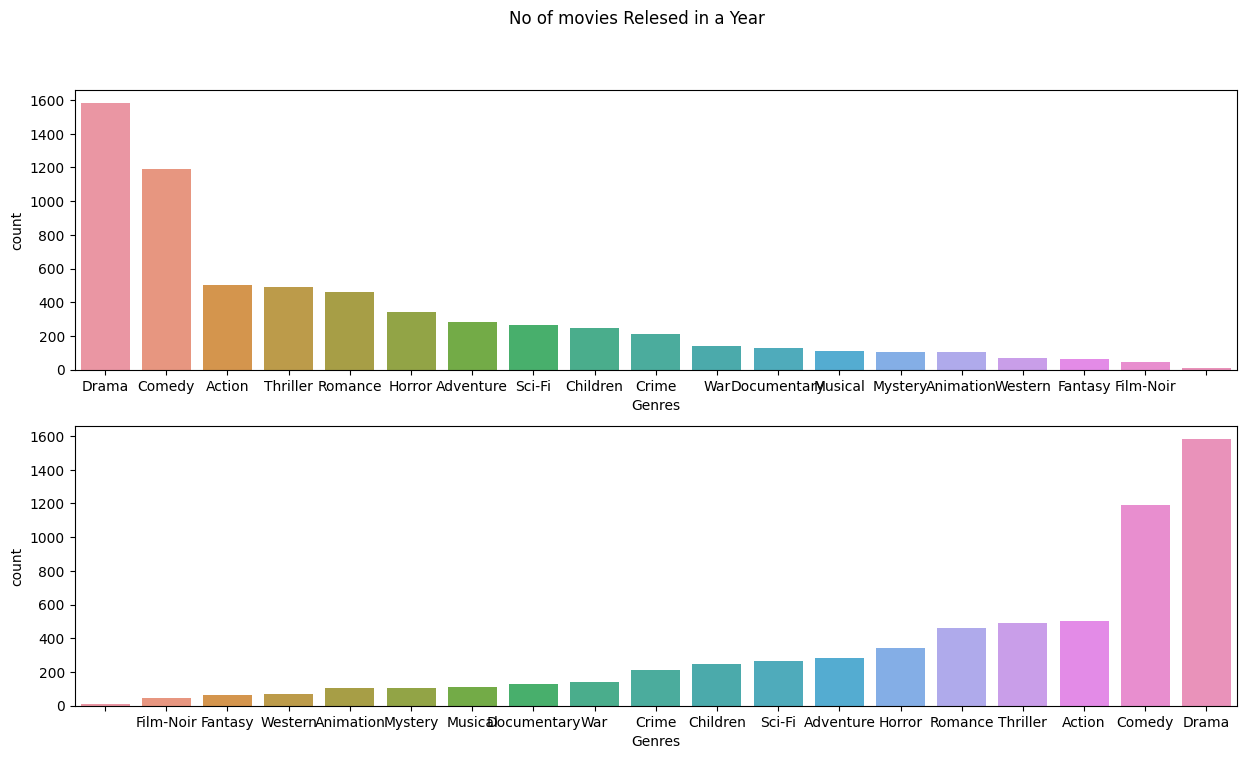

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# plot data on the first subplot
sns.countplot(data=movie_genres, x='Genres',order=movie_genres['Genres'].value_counts().iloc[:25].index,ax=axes[0])

# plot data on the second subplot
sns.countplot(data=movie_genres, x='Genres',order=movie_genres['Genres'].value_counts(ascending=True).iloc[:25].index,ax=axes[1])

# set overall title for the figure
fig.suptitle("No of movies Relesed in a Year")

# show the plot
plt.show()

In [35]:
# duplicates
movie_genres = df_movies.copy()
movie_genres['Genres'] = movie_genres['Genres'].str.split('|')
movie_genres = movie_genres.explode('Genres')
movie_genres.head()

,Movie_ID,Title,Genres,Release_year
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children's,1995
0,1,Toy Story,Comedy,1995
1,2,Jumanji,Adventure,1995
1,2,Jumanji,Children's,1995


In [36]:
arr=movie_genres.Genres.unique()
arr.sort()
arr

array(['', 'A', 'Acti', 'Action', 'Adv', 'Advent', 'Adventu', 'Adventur',
       'Adventure', 'Animati', 'Animation', 'Chi', 'Chil', 'Childr',
       'Childre', 'Children', "Children'", "Children's", 'Com', 'Come',
       'Comed', 'Comedy', 'Crime', 'D', 'Docu', 'Documen', 'Document',
       'Documenta', 'Documentary', 'Dr', 'Dram', 'Drama', 'F', 'Fant',
       'Fantas', 'Fantasy', 'Film-Noir', 'Horr', 'Horro', 'Horror',
       'Music', 'Musical', 'Mystery', 'R', 'Ro', 'Rom', 'Roma', 'Roman',
       'Romance', 'S', 'Sci', 'Sci-', 'Sci-F', 'Sci-Fi', 'Th', 'Thri',
       'Thrille', 'Thriller', 'Wa', 'War', 'We', 'Wester', 'Western'],
      dtype=object)

In [37]:
mapping = {'': '', 'A': 'Action', 'Acti': 'Action', 'Adv': 'Adventure', 'Advent': 'Adventure', 'Adventu': 'Adventure', 'Adventur': 'Adventure', 'Adventure': 'Adventure', 'Animati': 'Animation', 'Animation': 'Animation', 'Chi': 'Children', 'Chil': 'Children', 'Childr': 'Children', 'Childre': 'Children', 'Children': 'Children', "Children'": "Children", "Children's": "Children", 'Com': 'Comedy', 'Come': 'Comedy', 'Comed': 'Comedy', 'Comedy': 'Comedy', 'Crime': 'Crime', 'D': 'Documentary', 'Docu': 'Documentary', 'Documen': 'Documentary', 'Document': 'Documentary', 'Documenta': 'Documentary', 'Documentary': 'Documentary', 'Dr': 'Drama', 'Dram': 'Drama', 'Drama': 'Drama', 'F': 'Fantasy', 'Fant': 'Fantasy', 'Fantas': 'Fantasy', 'Fantasy': 'Fantasy', 'Film-Noir': 'Film-Noir', 'Horr': 'Horror', 'Horro': 'Horror', 'Horror': 'Horror', 'Music': 'Musical', 'Musical': 'Musical', 'Mystery': 'Mystery', 'R': 'Romance', 'Ro': 'Romance', 'Rom': 'Romance', 'Roma': 'Romance', 'Roman': 'Romance', 'Romance': 'Romance', 'S': 'Sci-Fi', 'Sci': 'Sci-Fi', 'Sci-': 'Sci-Fi', 'Sci-F': 'Sci-Fi', 'Sci-Fi': 'Sci-Fi', 'Th': 'Thriller', 'Thri': 'Thriller', 'Thrille': 'Thriller', 'Thriller': 'Thriller', 'Wa': 'War', 'War': 'War', 'We': 'Western', 'Wester': 'Western', 'Western': 'Western'}

# replace the values in the 'genre' column using the mapping
movie_genres['Genres'] = movie_genres['Genres'].replace(mapping)


In [38]:
arr=movie_genres.Genres.unique()
arr.sort()
arr

array(['', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

In [39]:
movie_genres['Genres'].value_counts()

Drama          1582
Comedy         1189
Action          503
Thriller        488
Romance         462
Horror          340
Adventure       282
Sci-Fi          265
Children        249
Crime           210
War             139
Documentary     127
Musical         113
Mystery         105
Animation       104
Western          68
Fantasy          63
Film-Noir        44
                  8
Name: Genres, dtype: int64

In [43]:
movie_genres[movie_genres['Genres']=='']

,Movie_ID,Title,Genres,Release_year
255,258,"Kid in King Arthur's Court, A",,1995
262,265,Like Water for Chocolate (Como agua para choco...,,1992
1187,1205,"Transformers: The Movie, The",,1986
1286,1306,Until the End of the World (Bis ans Ende der W...,,1991
1339,1360,Identification of a Woman (Identificazione di ...,,1982
2073,2142,"American Tail: Fievel Goes West, An",,1991
2636,2705,"Late August, Early September (Fin août, début ...",,1998
3794,3864,Godzilla 2000 (Gojira ni-sen mireniamu),,1999


In [46]:
movie_genres.loc[movie_genres['Genres'] == '', 'Movie_ID']

255      258
262      265
1187    1205
1286    1306
1339    1360
2073    2142
2636    2705
3794    3864
Name: Movie_ID, dtype: object

#### **Observation**: *There is no missing value in the given dataset for any attribute*

### Check for duplicates

In [92]:
# duplicates
movie_genre = df_movies.copy()
movie_genre['Genres'] = movie_genre['Genres'].str.split('|')
movie_genre = movie_genre.explode('Genres')
movie_genre.reset_index()
movie_genre.head()

,Movie_ID,Title,Genres,Release_year
0,1,Toy Story,Animation,1995
0,1,Toy Story,Children's,1995
0,1,Toy Story,Comedy,1995
1,2,Jumanji,Adventure,1995
1,2,Jumanji,Children's,1995


In [93]:
mapping = {'': '', 'A': 'Action', 'Acti': 'Action', 'Adv': 'Adventure', 'Advent': 'Adventure', 'Adventu': 'Adventure', 'Adventur': 'Adventure', 'Adventure': 'Adventure', 'Animati': 'Animation', 'Animation': 'Animation', 'Chi': 'Children', 'Chil': 'Children', 'Childr': 'Children', 'Childre': 'Children', 'Children': 'Children', "Children'": "Children", "Children's": "Children", 'Com': 'Comedy', 'Come': 'Comedy', 'Comed': 'Comedy', 'Comedy': 'Comedy', 'Crime': 'Crime', 'D': 'Documentary', 'Docu': 'Documentary', 'Documen': 'Documentary', 'Document': 'Documentary', 'Documenta': 'Documentary', 'Documentary': 'Documentary', 'Dr': 'Drama', 'Dram': 'Drama', 'Drama': 'Drama', 'F': 'Fantasy', 'Fant': 'Fantasy', 'Fantas': 'Fantasy', 'Fantasy': 'Fantasy', 'Film-Noir': 'Film-Noir', 'Horr': 'Horror', 'Horro': 'Horror', 'Horror': 'Horror', 'Music': 'Musical', 'Musical': 'Musical', 'Mystery': 'Mystery', 'R': 'Romance', 'Ro': 'Romance', 'Rom': 'Romance', 'Roma': 'Romance', 'Roman': 'Romance', 'Romance': 'Romance', 'S': 'Sci-Fi', 'Sci': 'Sci-Fi', 'Sci-': 'Sci-Fi', 'Sci-F': 'Sci-Fi', 'Sci-Fi': 'Sci-Fi', 'Th': 'Thriller', 'Thri': 'Thriller', 'Thrille': 'Thriller', 'Thriller': 'Thriller', 'Wa': 'War', 'War': 'War', 'We': 'Western', 'Wester': 'Western', 'Western': 'Western'}

# replace the values in the 'genre' column using the mapping
movie_genre['Genres'] = movie_genre['Genres'].replace(mapping)


In [94]:
movie_genre.reset_index(inplace=True)
movie_genre.drop_duplicates(inplace=True) 
movie_genre

,index,Movie_ID,Title,Genres,Release_year
0,0,1,Toy Story,Animation,1995
1,0,1,Toy Story,Children,1995
2,0,1,Toy Story,Comedy,1995
3,1,2,Jumanji,Adventure,1995
4,1,2,Jumanji,Children,1995
...,...,...,...,...,...
6336,3879,3949,Requiem for a Dream,Drama,2000
6337,3880,3950,Tigerland,Drama,2000
6338,3881,3951,Two Family House,Drama,2000
6339,3882,3952,"Contender, The",Drama,2000


In [114]:
movie_genre.head()

,Movie_ID,Title,Genres,Release_year
0,1,Toy Story,Animation,1995
1,1,Toy Story,Children,1995
2,1,Toy Story,Comedy,1995
3,2,Jumanji,Adventure,1995
4,2,Jumanji,Children,1995


In [ ]:
movie_ratings = pd.merge(df_rating, df_movies, on='movieId')

# calculate the mean rating for each movie
mean_ratings = movie_ratings.groupby(['title'])['rating'].mean().reset_index()

# create a pivot table with movie titles as rows and user ratings as columns
user_ratings = movie_ratings.pivot_table(index='userId', columns='title', values='rating')

# fill in missing values with zeros
user_ratings = user_ratings.fillna(0)

# calculate the Pearson Correlation between all pairs of movies
correlations = np.corrcoef(user_ratings.T)

# get the movie name from the user
movie_name = input("Enter a movie name: ")

# get the index of the movie in the correlations matrix
movie_idx = mean_ratings[mean_ratings['title'] == movie_name].index[0]

# get the Pearson Correlation coefficients for the selected movie
corrs = correlations[movie_idx]

# create a dataframe with the correlations and movie titles
similar_movies = pd.DataFrame({'title': user_ratings.columns, 'correlation': corrs})

# remove movies with a correlation of 1 (i.e., the selected movie itself)
similar_movies = similar_movies[similar_movies['correlation'] < 1]

# sort the movies by descending correlation
similar_movies = similar_movies.sort_values(by='correlation', ascending=False)

# select the top 5 most similar movies
recommendations = similar_movies.head(5)

# print the recommendations
print("Recommended movies based on Pearson Correlation for", movie_name, ":")
print(recommendations['title'].values)

In [116]:
# Create a user-movie ratings matrix
user_ratings = df_rating.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Calculate the Pearson Correlation coefficients
corr_matrix = user_ratings.corr(method='pearson', min_periods=50)



In [118]:
corr_matrix

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.143598,0.121563,NaN,NaN,0.081510,0.063226,0.235759,0.043349,0.285394,...,NaN,NaN,-0.029573,NaN,NaN,0.206280,-0.050742,NaN,-0.07499,0.072017
10,0.143598,1.000000,0.302085,NaN,NaN,0.530504,0.274561,0.226445,NaN,0.201044,...,NaN,NaN,0.150407,NaN,NaN,0.174836,0.386435,NaN,NaN,0.323403
100,0.121563,0.302085,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.200952,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.206280,0.174836,0.200952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.137575,NaN,NaN,1.000000,NaN,NaN,NaN,0.127477
996,-0.050742,0.386435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.270933
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:

# Find the movieId for the input movie
movie_id = movie_genre[movie_genre['Title'] == "Jumanji"]['Movie_ID'].iloc[0]
print(movie_id)

similar_movies = pd.DataFrame(corr_matrix[movie_id])
similar_movies = similar_movies.rename(columns={movie_id: 'correlation'})
similar_movies

2


,correlation
MovieID,
1,0.187467
10,0.254558
100,0.426156
1000,NaN
1002,NaN
...,...
994,0.111748
996,0.317623
997,NaN


In [132]:
similar_movies = similar_movies.join(movie_genre.set_index('Movie_ID'), on='MovieID')
similar_movies = similar_movies[similar_movies['correlation'] > 0.5].sort_values(by='correlation', ascending=False).head(6)
similar_movies

,correlation,Title,Genres,Release_year
MovieID,,,,
2,1.000000,Jumanji,Fantasy,1995
2,1.000000,Jumanji,Children,1995
2,1.000000,Jumanji,Adventure,1995
15,0.633272,Cutthroat Island,Action,1995
15,0.633272,Cutthroat Island,Adventure,1995
15,0.633272,Cutthroat Island,Romance,1995


In [133]:
similar_movies['MovieID']

KeyError: ignored

In [130]:
similar_movies = similar_movies[similar_movies['MovieID'] != movie_id]

# Print the recommended movies
print(f'Recommended movies similar to Toy Story":')
for title in similar_movies['title']:
    print(title)

KeyError: ignored

In [95]:
movie_genre.drop('index', axis=1, inplace=True)

In [100]:
df_rating.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [101]:

merged_df = pd.merge(movie_genre, df_rating, left_on='Movie_ID', right_on='MovieID')

New_Data = pd.merge(merged_df, df_users, on='UserID')
New_Data


,Movie_ID,Title,Genres,Release_year,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,Animation,1995,1,1,5,978824268,F,1,10,48067
1,1,Toy Story,Children,1995,1,1,5,978824268,F,1,10,48067
2,1,Toy Story,Comedy,1995,1,1,5,978824268,F,1,10,48067
3,48,Pocahontas,Animation,1995,1,48,5,978824351,F,1,10,48067
4,48,Pocahontas,Children,1995,1,48,5,978824351,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...,...
2059681,3536,Keeping the Faith,Romance,2000,5727,3536,5,958489902,M,25,4,92843
2059682,3555,U-571,Action,2000,5727,3555,3,958490699,M,25,4,92843
2059683,3555,U-571,Thriller,2000,5727,3555,3,958490699,M,25,4,92843
2059684,3578,Gladiator,Action,2000,5727,3578,5,958490171,M,25,4,92843


In [108]:

New_Data.drop(['Movie_ID'], axis=1, inplace=True)

In [109]:
New_Data

,Title,Genres,Release_year,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,Toy Story,Animation,1995,1,1,5,978824268,F,1,10,48067
1,Toy Story,Children,1995,1,1,5,978824268,F,1,10,48067
2,Toy Story,Comedy,1995,1,1,5,978824268,F,1,10,48067
3,Pocahontas,Animation,1995,1,48,5,978824351,F,1,10,48067
4,Pocahontas,Children,1995,1,48,5,978824351,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...
2059681,Keeping the Faith,Romance,2000,5727,3536,5,958489902,M,25,4,92843
2059682,U-571,Action,2000,5727,3555,3,958490699,M,25,4,92843
2059683,U-571,Thriller,2000,5727,3555,3,958490699,M,25,4,92843
2059684,Gladiator,Action,2000,5727,3578,5,958490171,M,25,4,92843


In [112]:
New_Data.reset_index(inplace=True)
New_Data.drop_duplicates(inplace=True) 

movie_user = New_Data.pivot(index='UserID', columns='Title', values='Title')
movie_user

ValueError: ignored

In [86]:
movie_genre =-movie_genre.isna()

In [87]:
movie_genre = movie_genre.astype(int)

In [88]:
movie_genre.shape

(3858, 19)

#### **Observation**: *There is no duplicate value in the given dataset*

In [89]:
movie_genre.head()

Genres,,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie_ID,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
100,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
df_rating

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### Dataset Copy

In [ ]:
movie_genre.corr()['Action'].sort_values(ascending=False).iloc[20]

0.01634086337895325


In [ ]:
def hamming_distance(x,Y):
  return sum(abs(x-Y))

### Delete irrelevant columns

In [ ]:
# Delete the columns that are not required/significant
work_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
work_df.shape

(1338, 7)

### Data categories

In [ ]:
# categorical_features=list(work_df.select_dtypes('object').columns)
cat_features = [x for x in work_df.columns if work_df[x].dtype == 'object']
cat_features

['sex', 'smoker', 'region']

In [ ]:
num_features = [y for y in work_df.columns if work_df[y].dtype not in ('object', 'datetime64[ns')]
num_features

['age', 'viral load', 'severity level', 'hospitalization charges']

In [ ]:
date_features = [z for z in work_df.columns if work_df[z].dtype == 'datetime']
date_features

[]

# Exploratory Data Analysis (EDA)

### Non-Graphical Analysis

#### Unique value counts of all attributes

#### Value Counts

In [ ]:
for col in work_df.columns:
    print(f"-----------------{col}------------------")
    attribute_cnt = {f'{col} Count' : work_df[col].value_counts()}
    attribute_cnt = pd.DataFrame(attribute_cnt)
    print(attribute_cnt)
    print("\n")

-----------------age------------------
    age Count
18         69
19         68
50         29
51         29
47         29
46         29
45         29
20         29
48         29
52         29
22         28
49         28
54         28
53         28
21         28
26         28
24         28
25         28
28         28
27         28
23         28
43         27
29         27
30         27
41         27
42         27
44         27
31         27
40         27
32         26
33         26
56         26
34         26
55         26
57         26
37         25
59         25
58         25
36         25
38         25
35         25
39         25
61         23
60         23
63         23
62         23
64         22


-----------------sex------------------
        sex Count
male          676
female        662


-----------------smoker------------------
     smoker Count
no           1064
yes           274


-----------------region------------------
           region Count
southeast           364
sout

In [ ]:
# Number of unique records for each columns
work_df.nunique()

age                          47
sex                           2
smoker                        2
region                        4
viral load                  462
severity level                6
hospitalization charges    1320
dtype: int64

In [ ]:
subset_df = work_df.iloc[:,[0,1,2,3,5]]
subset_df

,age,sex,smoker,region,severity level
0,19,female,yes,southwest,0
1,18,male,no,southeast,1
2,28,male,no,southeast,3
3,33,male,no,northwest,0
4,32,male,no,northwest,0
...,...,...,...,...,...
1333,50,male,no,northwest,3
1334,18,female,no,northeast,0
1335,18,female,no,southeast,0
1336,21,female,no,southwest,0


#### Value Counts

In [ ]:
# Value counts of subset of dataframe
for col in subset_df.columns:
    print(f"-----------------{col}------------------")
    attribute_cnt = {f'{col} Count' : subset_df[col].value_counts()}
    attribute_cnt = pd.DataFrame(attribute_cnt)
    print(attribute_cnt)
    print("/n")

-----------------age------------------
    age Count
18         69
19         68
50         29
51         29
47         29
46         29
45         29
20         29
48         29
52         29
22         28
49         28
54         28
53         28
21         28
26         28
24         28
25         28
28         28
27         28
23         28
43         27
29         27
30         27
41         27
42         27
44         27
31         27
40         27
32         26
33         26
56         26
34         26
55         26
57         26
37         25
59         25
58         25
36         25
38         25
35         25
39         25
61         23
60         23
63         23
62         23
64         22
/n
-----------------sex------------------
        sex Count
male          676
female        662
/n
-----------------smoker------------------
     smoker Count
no           1064
yes           274
/n
-----------------region------------------
           region Count
southeast           364
s

In [ ]:
# Value counts of certain attributes
for col in work_df.columns:
  if len(work_df[col].unique())<10:
    print(f"Column is: {col} and Values are:")
    print(work_df[col].unique())
    print()

Column is: sex and Values are:
['female' 'male']

Column is: smoker and Values are:
['yes' 'no']

Column is: region and Values are:
['southwest' 'southeast' 'northwest' 'northeast']

Column is: severity level and Values are:
[0 1 3 2 5 4]



### Graphical Analysis

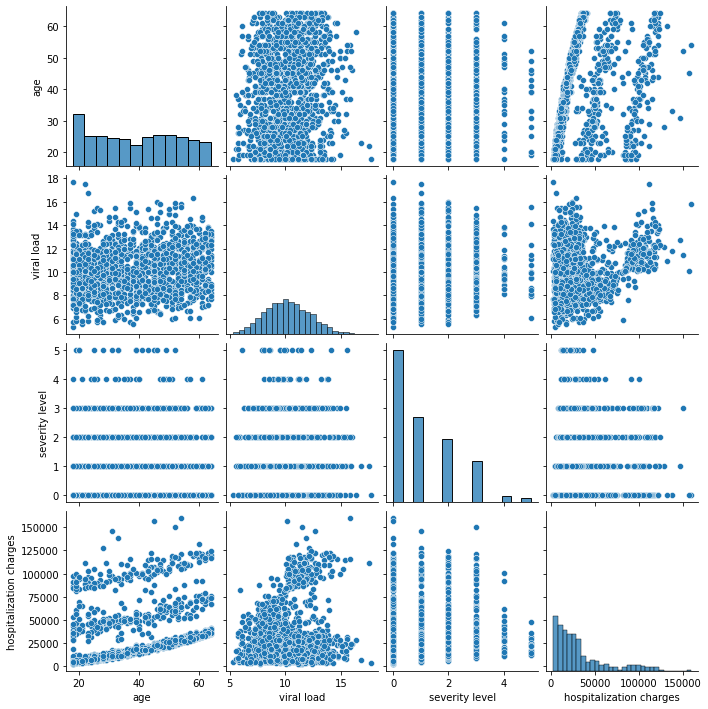

In [ ]:
sns.pairplot(work_df)

#### Univariate Analysis

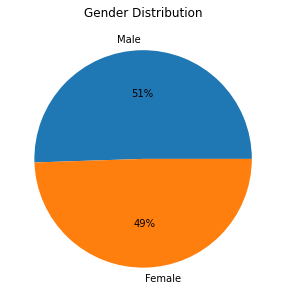

In [ ]:
plt.figure(figsize=(15,5))
plt.pie(work_df['sex'].value_counts(),labels=['Male','Female'], autopct='%.0f%%')
plt.title('Gender Distribution')
plt.show()

#### **Observation**: *Gender distribution amongst patients is almost same*

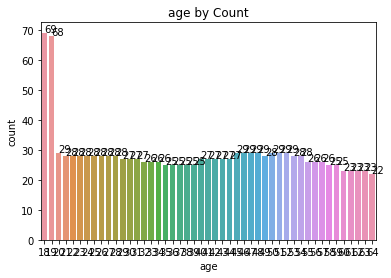

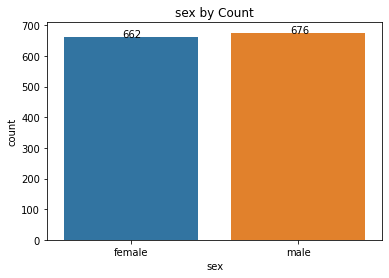

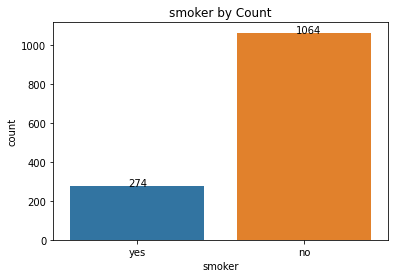

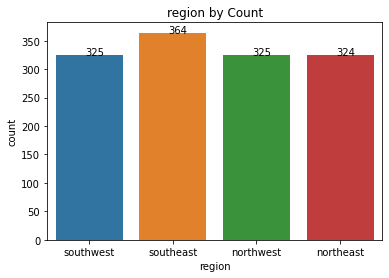

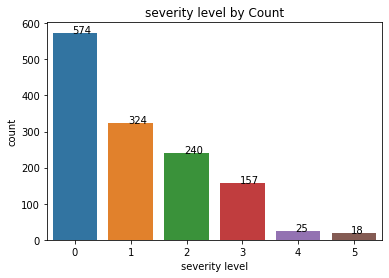

In [ ]:
# Count plot of attributes
for col in subset_df.columns:
  ax = sns.countplot(data=subset_df, x=col)
  plt.title(f"{col} by Count")
  for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.35, p.get_height()+0.05))
  plt.show()
  print()


#### **Observation**: 
*   *Age 18 & 19 have more patients and the rest of the ages have equal distribution*
*   *Interestingly Non-Smoker patients count is more than the Smokers count*
*   *Southeast region has more patients and the rest of the regions have equal distribution*
*   *Good to see less number of patients with 'Severity Level' high*

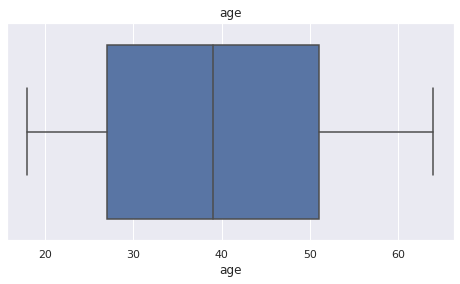

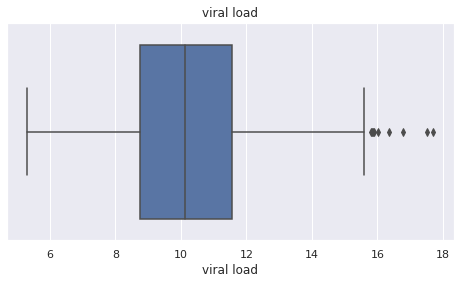

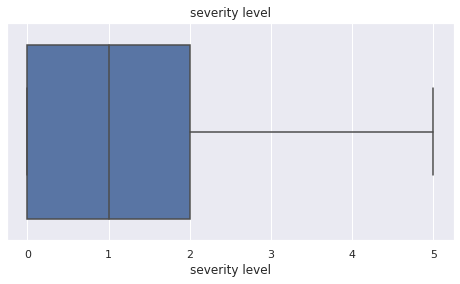

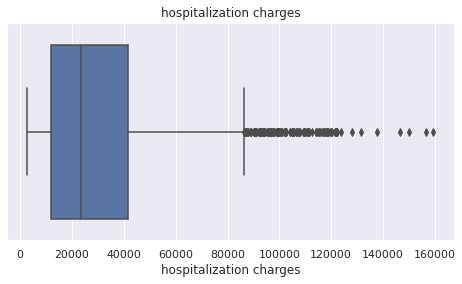

In [ ]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(8,4)})

for col in num_features:
  p = sns.boxplot(data=work_df,x=col)
  p.set(title=f'{col}')
  plt.show()

#### **Observation**: *The above charts indicate, we have outliers for 'viral load' and 'hospitalization charges'*

In [ ]:
def outlierAnalysis(x):
  Q3, Q1 = np.percentile(work_df[x], [75 ,25])
  IQR = Q3 - Q1
  maxExcludingOutlier = Q3 + 1.5 * IQR
  minExcludingOutlier = Q1 - 1.5 * IQR
  mean = round(work_df[x].mean(),2)
  median = round(work_df[x].median(),2)
  mode = round(work_df[x].mode(), 2)
  print("For the given sample" +x +"Analysis is as Follows: ")
  print("Q1: ", Q1)
  print("Q3: ", Q3)
  print("Mean: ", round(work_df[x].mean(),2))
  print("Median: ", work_df[x].median())
  print("Mode: " , round(work_df[x].mode(), 2))
  print("IQR: " , IQR)
  print("Maximum " + x +" Excluding Outlier: " , maxExcludingOutlier) 
  print("Minimum " + x + " Purchase Excluding Outlier: " , minExcludingOutlier)

In [ ]:
# outlier analysis of 'viral load'
outlierAnalysis('viral load')

For the given sampleviral loadAnalysis is as Follows: 
Q1:  8.7625
Q3:  11.5675
Mean:  10.22
Median:  10.13
Mode:  0     9.63
1    10.77
dtype: float64
IQR:  2.8050000000000015
Maximum viral load Excluding Outlier:  15.775000000000002
Minimum viral load Purchase Excluding Outlier:  4.554999999999997


In [ ]:
# outlier analysis of 'hospitalization charges'
outlierAnalysis('hospitalization charges')

For the given samplehospitalization chargesAnalysis is as Follows: 
Q1:  11851.0
Q3:  41599.5
Mean:  33176.06
Median:  23455.0
Mode:  0      4055
1      4080
2      4099
3      4319
4      4593
5      5509
6      5544
7      6773
8     11799
9     16501
10    20836
11    23618
12    26486
13    26504
14    33677
15    35003
16    35986
17    62288
dtype: int64
IQR:  29748.5
Maximum hospitalization charges Excluding Outlier:  86222.25
Minimum hospitalization charges Purchase Excluding Outlier:  -32771.75


#### Outlier Treatment

In [ ]:
# Remove the columns from the Numerical Features list where we don't have any outliers
num_features.remove('age')
num_features.remove('severity level')

In [ ]:
# Treat outliers for the numerical features where outliiers present
for i, j in enumerate(num_features):
  q1 = work_df[j].quantile(0.25)
  q3 = work_df[j].quantile(0.75)
  iqr = q3 - q1
  work_df = work_df[(work_df[j] >=  q1 - 1.5*iqr) & (work_df[j] <= q3 + 1.5*iqr)]

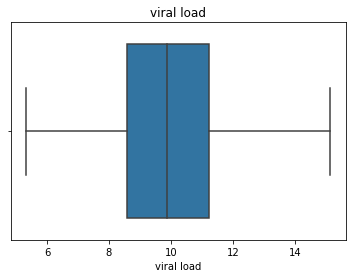

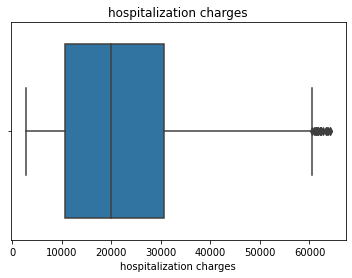

In [ ]:
# Plots post outlier treatment
for col in num_features:
  p = sns.boxplot(data=work_df,x=col)
  p.set(title=f'{col}')
  plt.show()

#### Bivariate Analysis

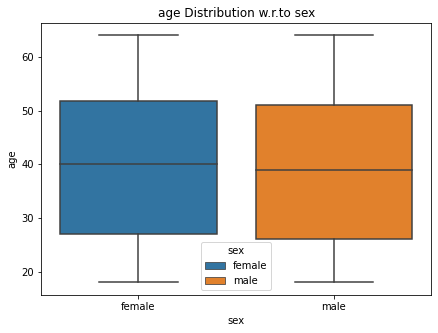

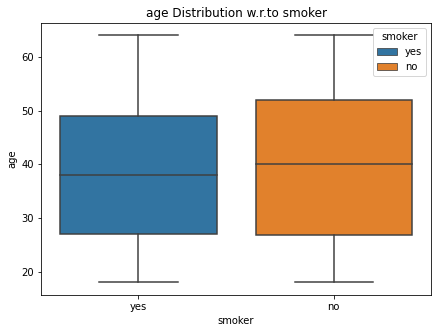

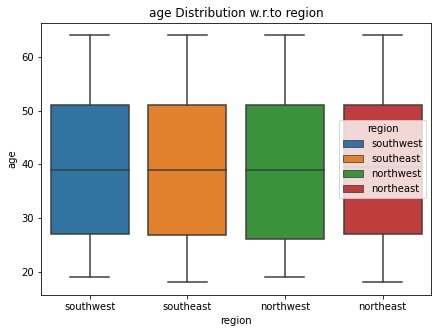

In [ ]:
# Bi-variate analysis of Categorical Features
variable = "age"
for i in cat_features:
 plt.figure(figsize = (7,5))
 sns.boxplot(x=i, hue=i, y=variable, data=work_df, dodge=False)
 plt.title(variable + " Distribution w.r.to " + i)
 plt.show()

#### **Observation**: 
*   *Most of the patients are seem to be b/w the ages 28 to 52 and equally distributed b/w both the gender*
*   *Similarly irrespective of smoking habit, the patients seem to be highly distributed b/w 28 and 50 ages*
*   *Similar distribution observed across the regions*



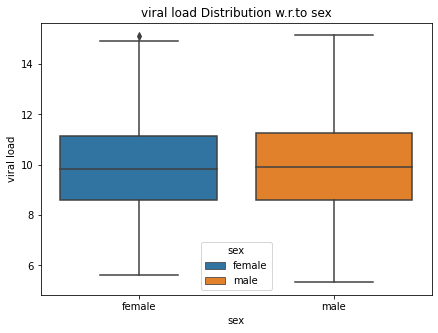

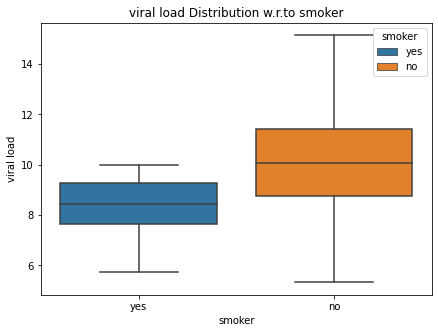

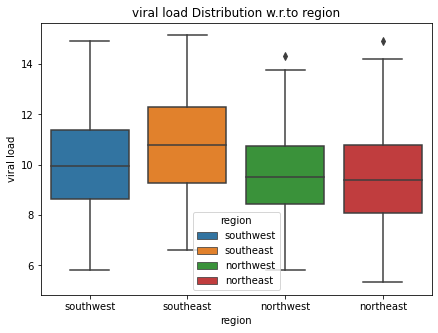

In [ ]:
variable = "viral load"
for i in cat_features:
 plt.figure(figsize = (7,5))
 sns.boxplot(x=i, hue=i, y=variable, data=work_df, dodge=False)
 plt.title(variable + " Distribution w.r.to " + i)
 plt.show()

#### **Observation**: 
*   *Female patients seems to be little more vulnerable to viral load than Male patients*
*   *Incidently non-smokers tend to have high viral load than smokers*
*   *Amongst the regions, Southeast is impacted with high viral load than other regions*



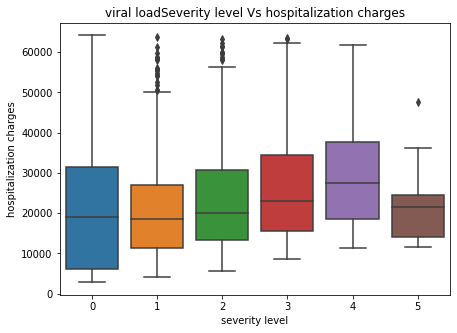

In [ ]:
# Impact of Severity Level on Hospitalization Charges
plt.figure(figsize = (7,5))
sns.boxplot(x='severity level', y='hospitalization charges', data=work_df, dodge=False)
plt.title(variable + "Severity level Vs hospitalization charges")
plt.show()

#### **Observation**: 
*   *Severity Levels 0, 3 and 4 seem to have higher hospitalization charges*



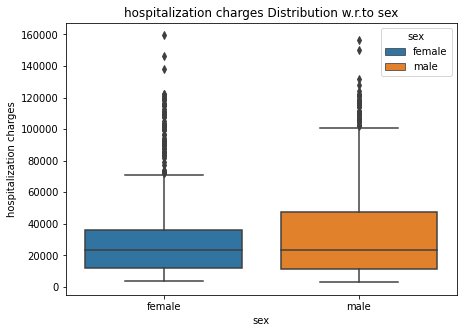

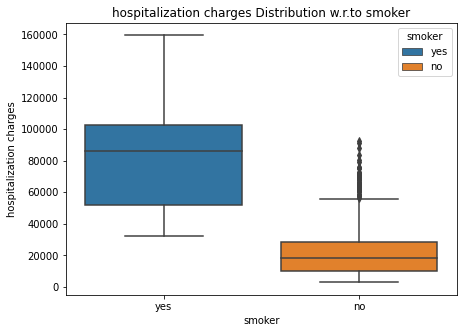

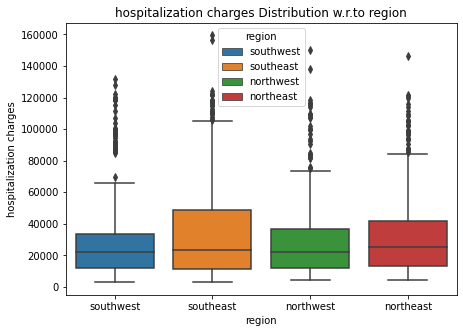

In [ ]:
variable = "hospitalization charges"
for i in cat_features:
 plt.figure(figsize = (7,5))
 sns.boxplot(x=i, hue=i, y=variable, data=work_df, dodge=False)
 plt.title(variable + " Distribution w.r.to " + i)
 plt.show()

#### **Observation**: In terms of hospitalization charges, 
*   *Male patients tend to incur high charges*
*   *Evidently Smokers are paying more than the non-smokers*
*   *Southeast region has higher hospitalization charges amongst regions*



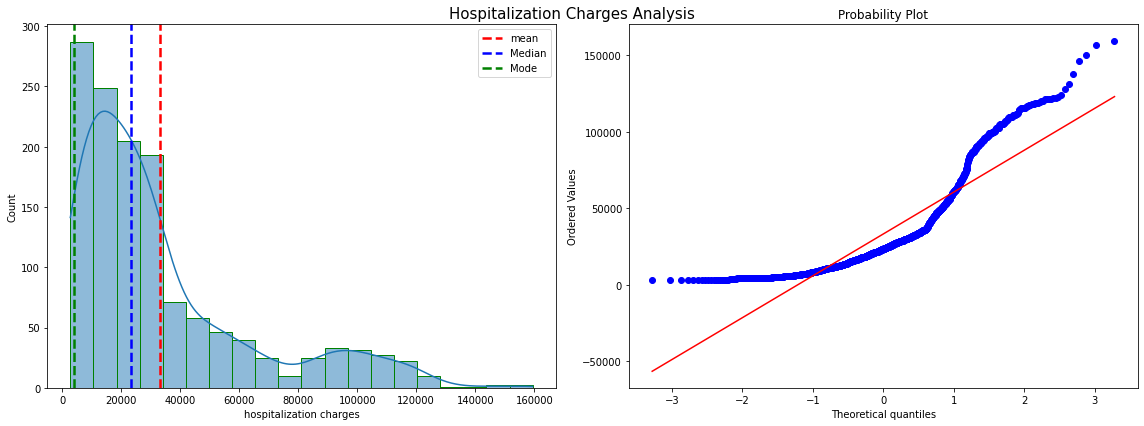

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), squeeze=False)
plt.suptitle("Hospitalization Charges Analysis", fontsize = 15)
g1 = sns.histplot(work_df['hospitalization charges'], kde = True, edgecolor='green', ax = axs[0, 0], bins = 20) 
g1.axvline(work_df['hospitalization charges'].mean(), ls = '--', color = "red", lw = 2.5, label = "mean") 
g1.axvline(work_df['hospitalization charges'].median(), ls = '--' ,color = 'blue', lw = 2.5, label = 'Median') 
g1.axvline(work_df['hospitalization charges'].mode()[0], ls = '--', color = 'green', lw = 2.5, label = 'Mode') 
g1.legend()
stats.probplot(work_df['hospitalization charges'], dist="norm", plot=axs[0, 1])
plt.tight_layout()
plt.show()

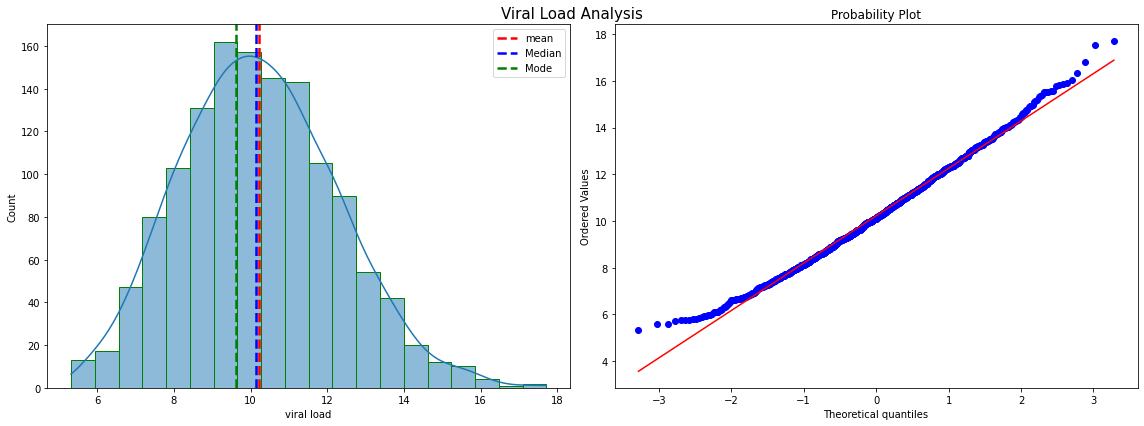

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), squeeze=False)
plt.suptitle("Viral Load Analysis", fontsize = 15)
g1 = sns.histplot(work_df['viral load'], kde = True, edgecolor='green', ax = axs[0, 0], bins = 20) 
g1.axvline(work_df['viral load'].mean(), ls = '--', color = "red", lw = 2.5, label = "mean") 
g1.axvline(work_df['viral load'].median(), ls = '--' ,color = 'blue', lw = 2.5, label = 'Median') 
g1.axvline(work_df['viral load'].mode()[0], ls = '--', color = 'green', lw = 2.5, label = 'Mode') 
g1.legend()
stats.probplot(work_df['viral load'], dist="norm", plot=axs[0, 1])
plt.tight_layout()
plt.show()

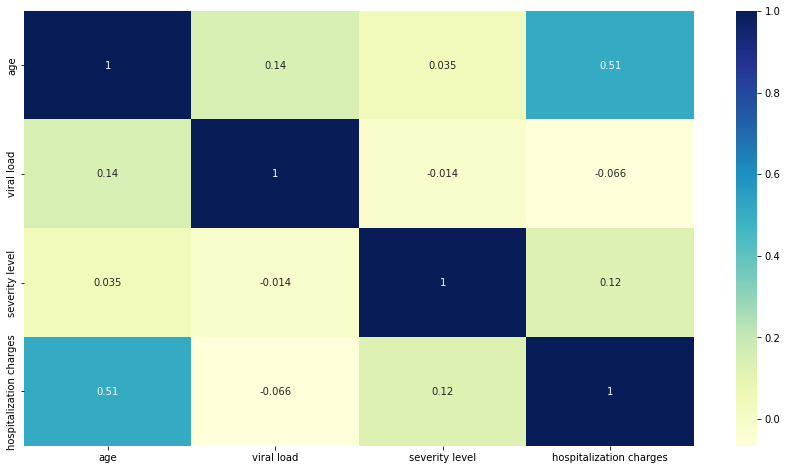

In [ ]:
# Check for Correlation
plt.figure(figsize=(15,8))
sns.heatmap(work_df.corr(), annot=True, cmap='YlGnBu')
plt.show()

#### **Observation**: *Notably, there is a high correlatioin b/w Age & Hospitalization Charges*

In [ ]:
work_df['age_bins'] = pd.cut(x=work_df['age'], bins = [0, 18, 35, 50, 70, 100], labels = ['0-18', '18-35', '35-50', '50-70', '70-100'])
work_df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges,age_bins
0,19,female,yes,southwest,9.30,0,42212,18-35
1,18,male,no,southeast,11.26,1,4314,0-18
2,28,male,no,southeast,11.00,3,11124,18-35
3,33,male,no,northwest,7.57,0,54961,18-35
4,32,male,no,northwest,9.63,0,9667,18-35


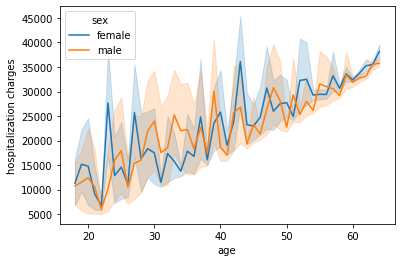

In [ ]:
sns.lineplot(x='age', y='hospitalization charges', data=work_df, hue='sex')

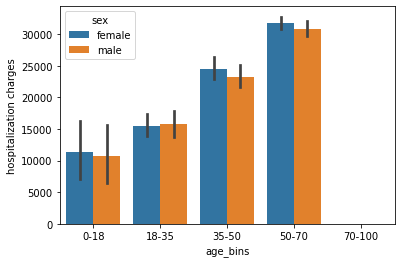

In [ ]:
sns.barplot(x='age_bins', y='hospitalization charges', data=work_df, hue='sex')

#### **Observation**: *It is evident from the above graphs that hospitalization charges increase with the age and that too in women segment*

In [ ]:
work_df.groupby(['region', 'sex', 'smoker']).mean()['hospitalization charges'].unstack()

smoker                      no           yes
region    sex                               
northeast female  22013.256000  46492.823529
          male    19633.533333  46155.153846
northwest female  20019.523077  48740.166667
          male    18420.714286  48740.666667
southeast female  18421.461538  49618.000000
          male    17718.819672  48649.357143
southwest female  18842.235294  45495.000000
          male    18778.569106  48505.833333

In [ ]:
# Hospitalization charges max by region by sex and by smoking habit
hosp_charge_max_by_region = work_df.groupby(['region', 'sex', 'smoker']).max()['hospitalization charges'].sort_values().unstack()
hosp_charge_max_by_region

smoker               no    yes
region    sex                 
northeast female  58222  60267
          male    58104  56155
northwest female  60149  59719
          male    56234  59918
southeast female  55481  60452
          male    58908  55545
southwest female  50444  56196
          male    57707  58921

In [ ]:
# Hospitalization charges min by region by sex and by smoking habit
hosp_charge_min_by_region = work_df.groupby(['region', 'sex', 'smoker']).min()['hospitalization charges'].sort_values().unstack()
hosp_charge_min_by_region

smoker              no    yes
region    sex                
northeast female  5491  35709
          male    4237  32074
northwest female  5293  36779
          male    4053  39545
southeast female  4019  41444
          male    2805  42608
southwest female  4319  34611
          male    3104  39552

### Hypothesis Testing

#### Prove (or disprove) that the hospitalization of people who do smoking is greater than those who don't? (T-test Right tailed)

In [ ]:
# Hypothesis 1 - Hospitalization of people who are smokers is greater than the non-smokers
work_df.groupby('smoker')['hospitalization charges'].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1012.0,19229.271739,11641.575233,2805.0,9692.0,17880.0,27420.75,60149.0
yes,99.0,47808.929293,6808.260660,32074.0,42830.0,47769.0,53103.50,60452.0


##### 

Null Hypothesis :  Mean Hospitalization charges of Smokers (m1) <= the Mean Hospitalization charges of nonsmokers (m2)

Alternate Hypothesis: m1 > m2 (The average hospitalization charges of smokers is greater than that of nonsmokers)

Decide the significance level. If P values is less than alpha, then 'fail to accept' the null hypothesis.

Let's do a T-stat test. The > sign in alternate hypothesis indicate test is right tailed, which means all z values that would reject null hypothesis are in just one tail to the right of sampling distribution curve.

In [ ]:
# Mean value of Smokers and their hospitalization charges from a random sample
smoker_sample = df[df['smoker']=='yes']['hospitalization charges'].sample(200)
m1 = smoker_sample.mean()
m1

79681.65

In [ ]:
# Mean value of Non-smokers and their hospitalization charges from a random sample
non_smoker_sample = df[df['smoker']=='no']['hospitalization charges'].sample(200)
m2 = non_smoker_sample.mean()
m2

18982.11

In [ ]:
# If mean1 is > mean2 then alternate value is 'greater' else it is 'less' else if mean1 equal to mean2 then the value is 'two-sided'
alpha = 0.05
alt_val = ["greater" if m1>m2 else 'two-sided' if m1==m2 else "less"]
t_stat, p_val = stats.ttest_ind(smoker_sample, non_smoker_sample, equal_var=False, alternative=alt_val[0])
print("Test Statistic = {}, P-Value = {}, One Tail P-Value = {}".format(t_stat, p_val, p_val_onetail))
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

Test Statistic = 27.088426845510426, P-Value = 2.149878888748719e-81, One Tail P-Value = 1.0749394443743594e-81
We fail to accept the null hypothesis


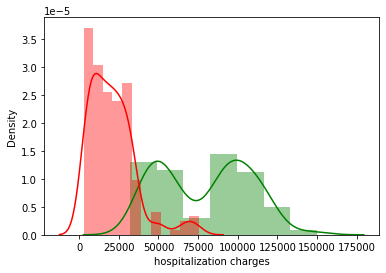

In [ ]:
sns.distplot(smoker_sample, color='green')
sns.distplot(non_smoker_sample, color='red')

#### Prove (or disprove) with statistical evidence that the viral load of females is different from that of males (T-test Two tailed)

##### 

Null Hypothesis : the viral load of females is different from that of males

Alternate Hypothesis: the viral load of females is not different from that of males

Decide the significance level. If P values is less than alpha, then 'fail to accept' the null hypothesis.

In [ ]:
work_df.groupby('sex')['viral load'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,569.0,9.952285,1.944578,5.60,8.58,9.860,11.1800,15.11
male,542.0,10.003653,1.931349,5.32,8.58,9.935,11.2975,15.14


In [ ]:
male_sample = work_df[work_df['sex']=='male']['viral load'].sample(500)
male_mean = male_sample.mean()
male_mean

10.339899999999998

In [ ]:
female_sample = work_df[work_df['sex']=='female']['viral load'].sample(500)
fem_mean = female_sample.mean()
fem_mean

10.04166

In [ ]:
# As the means of both the samples of male and female, let's do 'two-sided'.
alpha = 0.05
t_stat, p_val = stats.ttest_ind(male_sample, female_sample)
print("Test Statistic = {}, P-Value = {}".format(t_stat, p_val))
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

Test Statistic = 2.297856074924988, P-Value = 0.021776091551530378
We fail to accept the null hypothesis


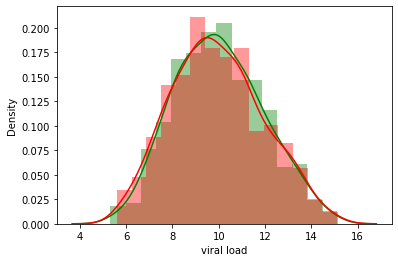

In [ ]:
sns.distplot(male_sample, color='green')
sns.distplot(female_sample, color='red')

#### **Observation**: *We fail to reject the Null hypothesis, which means gender doesn't have much effect on Viral load*

### Chi-Squared Test

#### Is the proportion of smoking significantly different across different regions? (Chi-square)

Both Smoker and Region are categorical variables

#####

Null Hypothesis : Smokers proportions is same across all regions

Alternate Hypothesis: Smokers proportions is different across different regions

If P values is less than alpha, then 'fail to accept' the null hypothesis.

In [ ]:
contingency = pd.crosstab(work_df.region, work_df.smoker)
contingency

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


In [ ]:
chi2, p_val, dof, exp_freq = chi2_contingency(contingency, correction=False)
print("Chi Square Statistic: {}, P-Value: {}, Degree of Freedom: {}, Expected Frequency: {}".format(chi2, p_val, dof, exp_freq))
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

Chi Square Statistic: 7.343477761407071, P-Value: 0.06171954839170541, Degree of Freedom: 3, Expected Frequency: [[257.65022422  66.34977578]
 [258.44544096  66.55455904]
 [289.45889387  74.54110613]
 [258.44544096  66.55455904]]
We fail to reject the null hypothesis


### ANOVA Test

#### Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same? Explain your answer with statistical evidence (One way Anova)

#####

Null Hypothesis : The mean viral load of women with no severity level μ1, one severity level μ2 and two severity level μ3 are the same.  

Alternate Hypothesis: μ1 or μ2 or μ3 may not be same.

If P values is less than alpha, then 'fail to accept' the null hypothesis.

In [ ]:
work_df[work_df['sex']=='female'].groupby('severity level')['viral load'].describe().head()

,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,249.0,10.016426,1.962150,5.76,8.6300,9.870,11.3000,14.92
1,138.0,9.822609,1.854912,5.60,8.5850,9.655,11.0100,15.11
2,98.0,9.879184,2.012418,5.73,8.2550,10.010,11.1650,14.45
3,68.0,10.042353,1.968850,6.33,8.6075,10.035,11.3175,14.90
4,9.0,10.681111,1.906321,8.53,9.6000,9.770,11.2300,13.82


In [ ]:
# female_severity_df = work_df[work_df['sex']=='female'].loc[work_df[work_df['sex']=='female']['severity level']<=2]
female_severity_df = work_df[work_df['sex']=='female'].loc[work_df[work_df['sex']=='female']['severity level']<=2]
female_severity_df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
5,31,female,no,southeast,8.58,0,9392
6,46,female,no,southeast,11.15,1,20601
9,60,female,no,northwest,8.61,0,72308
11,62,female,yes,southeast,8.76,0,69522


In [ ]:
# Shapiro-Wilk’s test - Let's test null hypothesis: viral load follows normal distribution against the alternative hypothesis: viral load doesn't follow normal distribution
w, p_val = shapiro(female_severity_df['viral load'])
print("P-Value is: ", p_val)
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

P-Value is:  0.011093495413661003
We fail to accept the null hypothesis


#### **Observation**: *Null hypothesis fails, which means it doesn't follow normal distribution. This can be validated by EDA as follows*

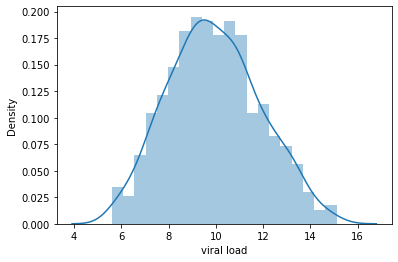

In [ ]:
sns.distplot(female_severity_df['viral load'], bins=20)

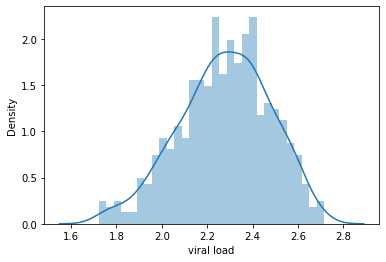

In [ ]:
sns.distplot(np.log(female_severity_df['viral load']), bins=30)

In [ ]:
# For the same above Ho and H1, let's do a log normal test and check the p-value. 
w, p_val = shapiro(np.log(female_severity_df['viral load']))
print('P-Value is: ', p_val)
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

P-Value is:  0.006363806780427694
We fail to accept the null hypothesis


#### **Observation**: *Even the log normal test fails the Ho, which means the distribution is not normal*

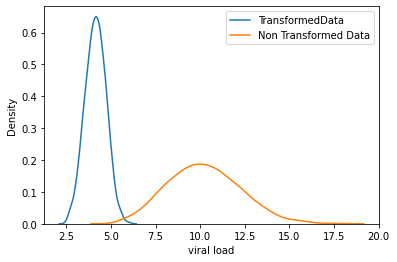

In [ ]:
transformed_data, best_lambda = stats.boxcox(work_df['viral load']) 
sns.distplot(transformed_data, hist=False, kde=True, label = "TransformedData") 
sns.distplot(work_df['viral load'], hist=False, kde=True, label = "Non Transformed Data") 
plt.legend()
plt.show()

In [ ]:
tstat, p_val = stats.shapiro(transformed_data)
print('P-Value is: ', p_val)
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

P-Value is:  0.34881141781806946
We fail to reject the null hypothesis


#### **Observation**: *Boxcox transformation technique for viral load indicates p-value > alpha. So distribution is Normal on transformed data*

#### Levene’s test

Null hypothesis : All the viral load variances are equal

Alternative hypothesis : At least one variance is different from the rest.

In [ ]:
# Levene's test
statistics, p_val = levene(female_severity_df[female_severity_df['severity level']==0]['viral load'].sample(100), 
                           female_severity_df[female_severity_df['severity level']==1]['viral load'].sample(100),
                           female_severity_df[female_severity_df['severity level']==2]['viral load'].sample(100, replace=True))
print('P-Value is: ', p_val)
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

P-Value is:  0.1716618340538876
We fail to reject the null hypothesis


In [ ]:
test_stat, p_val = f_oneway(female_severity_df[female_severity_df['severity level']==0]['viral load'].sample(100), 
                            female_severity_df[female_severity_df['severity level']==1]['viral load'].sample(100),
                            female_severity_df[female_severity_df['severity level']==2]['viral load'].sample(100, replace=True))
print('P-Value is: ', p_val)
if p_val > alpha:
  print("We fail to reject the null hypothesis")
else:
  print("We fail to accept the null hypothesis")

P-Value is:  0.31898469765817655
We fail to reject the null hypothesis


#### **Observation**: *P-Value is high, thus Null Hypothesis is true, indicating Means are equal for all severity levels.*

# Observations & Insights



*   There is no missing or duplicate value in the given dataset
*   Age 18 & 19 have more patients and the rest of the ages have equal distribution
*   Interestingly Non-Smoker patients count is more than the Smokers count
*   Southeast region has more patients and the rest of the regions have equal distribution
*   Good to see less number of patients with 'Severity Level' high
*   There are outliers in 'viral load' and 'hospitalization charges' columns
*   There is a high correlatioin b/w Age & Hospitalization Charges. As the age increases, hospitalization charges also increases
*   Also, hospitalization seem to increase with the age, and more specifically for women   
*   Female patients seems to be little more vulnerable to viral load than Male patients
*   Incidently non-smokers tend to have high viral load than smokers
*   Amongst regions, Southeast is impacted high viral load than other regions
*   Male patients tend to incur high charges
*   Evidently Smokers are paying more than the non-smokers
*   Southeast region has higher hospitalization charges amongst regions
*   Hospitalization charges increase with age and that too in women segment

**Observations from Hypothesis Testing:**

*   Hospitalization Charges for smokers is higher than for non-smokers
*   Viral Load in Females is more compared to Males
*   Proportion of smoking is almost similar across the regions
*   Viral Load of women with Severity levels - 0,1,2 are more or less same




# Recommendations

Based on the above observations and insights, some of the recommendations to consider are: 
*   It is alarming to see high number of patients at lower age group 18-20. It's high time to role out stable nutrition programs for children & teens.
*   Notably Southeast region is impacted with high viral load and increased hospitalization charges. Special attention needs to be given in this region
*   As age has direct proportion to the increased hospitalization charges, Apollo can come up with targeted healthcare policy & programs for higher age groups
*   Female gender group requires specific, focused attention 
*   Special medi-claim policy can be launced for Smokers 